In [1]:
import sys
import numpy as np
import xarray as xr
import itertools as it
import os.path
import multiprocessing as mp
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.rcsetup as rcsetup
import tensorflow as tf
import sklearn
from keras.layers import *
from keras.regularizers import l1,l2
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.losses import mean_squared_error
from keras import backend as K
from livelossplot.keras import PlotLossesCallback

CPU_COUNT = mp.cpu_count()
print('{} CPUs'.format(CPU_COUNT))
print('numpy version: {}'.format(np.__version__))
print('xarray version: {}'.format(xr.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
print('sklearn version: {}'.format(sklearn.__version__))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Using TensorFlow backend.


4 CPUs
numpy version: 1.16.3
xarray version: 0.12.1
matplotlib version: 3.0.3
sklearn version: 0.20.3


In [2]:
use_data_caching = True
keep_original_data_loaded = False
experiment = 'rcp26'

X_all_filename = './data/X_{}_all.npy'.format(experiment)
X_train_filename = './data/X_{}_train.npy'.format(experiment)
X_valid_filename = './data/X_{}_valid.npy'.format(experiment)
if use_data_caching and os.path.isfile(X_all_filename):
    print('loading cached data file {}'.format(X_all_filename))
    X_all = np.load(X_all_filename)
else:
    print('loading and processing dataset for experiment {}'.format(experiment))
    X_ds = xr.open_dataset('./data/{0}/{0}_m6_tas_pr.nc'.format(experiment))
    X_arr = X_ds.to_array().transpose('model', 'time', 'lat', 'lon', 'variable')
    X_all = X_arr.values
    nan_count = np.product(X_all.shape) - np.count_nonzero(~np.isnan(X_all))
    print('found {} NaN values in data'.format(nan_count))
    assert nan_count == 0
    # standardize variables
    for i in range(N_vars):
        stddev = np.std(X_all[:,:,:,:,i])
        X_all[:,:,:,:,i] = X_all[:,:,:,:,i] / stddev
    if use_data_caching:
        np.save(X_all_filename, X_all)
    
N_models, N_time, N_lat, N_lon, N_vars = X_all.shape
BATCH_SIZE = N_models*N_time / 20
    
N_models_train = N_models - 2
N_models_valid = N_models - N_models_train

if use_data_caching and os.path.isfile(X_train_filename):
    print('loading cached data file {}'.format(X_train_filename))
    X_train = np.load(X_train_filename)
else:
    print('generating training data')
    X_train = np.hstack(X_all[:N_models_train]).reshape((N_models_train*N_time, N_lat, N_lon, N_vars))
    if use_data_caching:
        np.save(X_train_filename, X_train)

if use_data_caching and os.path.isfile(X_valid_filename):
    print('loading cached data file {}'.format(X_valid_filename))
    X_valid = np.load(X_valid_filename)
else:
    print('generating validation data')
    X_valid = np.hstack(X_all[N_models_train:]).reshape((N_models_valid*N_time, N_lat, N_lon, N_vars))
    if use_data_caching:
        np.save(X_valid_filename, X_valid)

if not keep_original_data_loaded:
    del X_all
print('Loaded training data with shape: {}'.format(X_train.shape))
print('Loaded validation data with shape: {}'.format(X_valid.shape))

loading cached data file ./data/X_rcp26_all.npy
loading cached data file ./data/X_rcp26_train.npy
loading cached data file ./data/X_rcp26_valid.npy
Loaded training data with shape: (11520, 72, 144, 2)
Loaded validation data with shape: (5760, 72, 144, 2)


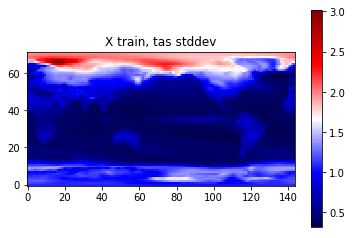

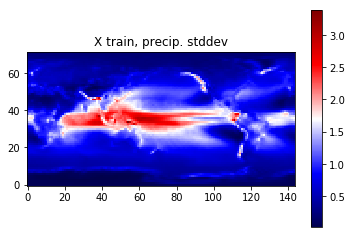

In [3]:
X_std = np.std(X_train, axis=0)
plt.imshow(X_std[:,:,0], origin='lower', cmap='seismic')
plt.colorbar()
plt.title('X train, tas stddev')
plt.show()
plt.imshow(X_std[:,:,1], origin='lower', cmap='seismic')
plt.colorbar()
plt.title('X train, precip. stddev')
plt.show()

In [4]:
def plot_var_spatial(X, model, name="model", t=0, c=0):
    X_t = np.expand_dims(X[t], axis=0)
    X_pred = model.predict(X_t)[0,:,:,c]
    plt.figure(figsize=(12,10))
    plt.subplot(1,2,1)
    plt.imshow(X_t[0,:,:,c], origin='lower')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title("{}, t={}".format(name, t))
    plt.subplot(1,2,2)
    plt.imshow(X_pred, origin='lower')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title("{}, t={}, reconstructed".format(name, t))
    plt.show()
    
def plot_err_spatial(X, model, target_shape=(1, N_lat, N_lon, N_vars), name="", t=0,c=0):
    plt.figure(figsize=(7,6))
    X_t = np.expand_dims(X[t], axis=0)
    X_pred = model.predict(X_t)
    X_err = np.abs(X_t - X_pred)[0,:,:,c]
    print(X_err.shape)
    plt.imshow(X_err.reshape((N_lat, N_lon)), origin='lower')
    plt.colorbar()
    plt.title("{}, total abs err, t={}, reconstructed".format(name, t))
    plt.show()
    
def plot_var_time(X, model, name="", c=0):
    X_orig = X
    X_pred = np.zeros((0, *X_orig.shape[1:]))
    batch_size = X_orig.shape[0] // 10
    for i in range(10):
        X_next = model.predict_on_batch(X_orig[i*batch_size:(i+1)*batch_size])
        X_pred = np.concatenate([X_pred, X_next], axis=0)
    plt.plot(range(X_orig.shape[0]), np.mean(X_orig, axis=(1,2))[:,c], c='blue')
    plt.title('{}, global average, original'.format(name))
    plt.plot(range(X_orig.shape[0]), np.mean(X_pred, axis=(1,2))[:,c], ':', c='red')
    plt.title('{}, global average, reconstructed'.format(name))
    plt.show()
    
def show_activations(X, model, layer, output_shape, t=0, name=""):
    inputs = [K.learning_phase()] + model.inputs
    layer_fn = K.function(inputs, [layer.output])
    layer_out = layer_fn([0, X.reshape((1, *X.shape))])[0]
    z_0 = z[t].reshape(output_shape)
    plt.imshow(z_0, origin='lower')
    plt.colorbar()
    plt.show()

### Dense Autoencoder

In [22]:
def build_dense_autoencoder(latent_dims: int, regularizer=l1(1.0e-5)):
    input_0 = Input(shape=(N_lat, N_lon, N_vars))
    z = Dense(latent_dims, activation='relu', kernel_regularizer=regularizer)(Flatten()(input_0))
    def build_decoder(input_z):
        dense_out = Dense(N_lat*N_lon*N_vars, activation='linear')(input_z)
        output = Reshape((N_lat, N_lon, N_vars))(dense_out)
        return output
    output_0 = build_decoder(z)
    # build standalone encoder/decoder
    encoder = Model(inputs=input_0, outputs=z)
    decoder_input = Input(shape=(latent_dims,))
    decoder_output = build_decoder(decoder_input)
    decoder = Model(inputs=decoder_input, outputs=decoder_output)
    dae = Model(inputs=input_0, outputs=output_0)
    dae.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return dae, encoder, decoder

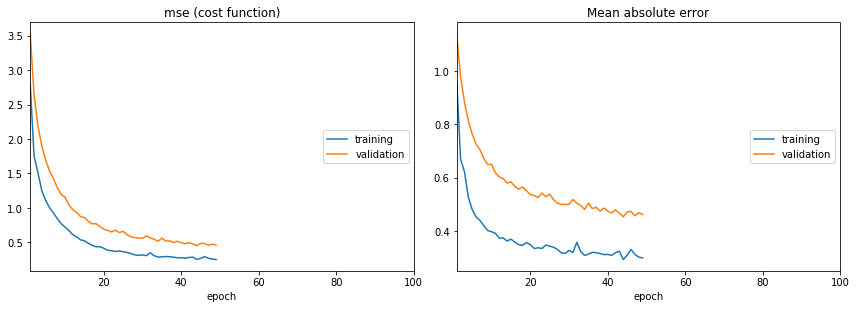

mse (cost function):
training   (min:    0.249, max:    2.800, cur:    0.250)
validation (min:    0.451, max:    3.529, cur:    0.461)

Mean absolute error:
training   (min:    0.293, max:    0.960, cur:    0.299)
validation (min:    0.453, max:    1.140, cur:    0.462)


In [35]:
dae, dae_encoder, dae_decoder = build_dense_autoencoder(latent_dims=18*36)
callbacks = [EarlyStopping(min_delta=1.0E-3, patience=5), PlotLossesCallback()]
dae.fit(X_train, X_train, validation_data=(X_valid, X_valid), \
        batch_size=BATCH_SIZE, epochs=100, shuffle=True, callbacks=callbacks)

In [35]:
plot_var_spatial(X_valid, dae, name="tas, decoded (validation set)", c=0)
plot_var_spatial(X_valid, dae, name="precip, decoded (validation set)", c=1)
plot_err_spatial(X_valid, dae, name="tas", c=0)
plot_err_spatial(X_valid, dae, name="precip", c=1 )
plot_var_time(X_valid, dae, c=0, name='tas')
plot_var_time(X_valid, dae, c=1, name='precip')
show_activations(X_valid, dae, dae.layers[2], (18,36))

NameError: name 'dae' is not defined

### Convolutional model

In [15]:
def build_conv_autoencoder(n_filters: int, n_downsamples: int = 2, regularizer = l2(1.0E-5)):
    assert n_downsamples > 0
    assert n_downsamples < N_lat / 2
    relu = ReLU()
    def conv_encoder(prev_layer):
        conv_0 = Conv2D(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        conv_1 = Conv2D(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        conv_dn = Conv2D(n_filters, (3,3), strides=(2,2), kernel_regularizer=regularizer, padding='same')
        return relu (conv_dn (relu (conv_1 (relu (conv_0 (prev_layer))))))
    def conv_decoder(prev_layer):
        tconv_0 = Conv2DTranspose(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        tconv_1 = Conv2DTranspose(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        tconv_up = Conv2DTranspose(n_filters, (3,3), strides=(2,2), kernel_regularizer=regularizer, padding='same')
        return relu (tconv_up (relu (tconv_1 (relu (tconv_0 (prev_layer))))))
    def build_decoder(input_z):
        z_reshape = Reshape((latent_x,latent_y,1))
        h_decoder = z_reshape(input_z)
        for i in range(n_downsamples):
            h_decoder = conv_decoder(h_decoder)
        conv_out = Conv2D(N_vars, (3,3), padding='same')
        return conv_out(h_decoder)
    
    latent_x, latent_y = int(N_lat / 2**n_downsamples), int(N_lon / 2**n_downsamples)
    latent_dims = latent_x*latent_y
    input_0 = Input(shape=(N_lat, N_lon, N_vars))
    h_encoder = input_0
    for i in range(n_downsamples):
        h_encoder = conv_encoder(h_encoder)
    z = Dense(latent_dims, kernel_regularizer=regularizer)(Flatten()(h_encoder))
    output_0 = build_decoder(relu(z))
    # build encoder/decoder models
    encoder = Model(inputs=input_0, outputs=z)
    decoder_input = Input(shape=(latent_dims,))
    decoder_output = build_decoder(decoder_input)
    decoder = Model(inputs=decoder_input, outputs=decoder_output)
    # build end-to-end model
    cae = Model(inputs=input_0, outputs=output_0)
    cae.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return cae, encoder, decoder, latent_dims

In [94]:
conv_model, conv_encoder, conv_decoder, conv_latent_dims = build_conv_autoencoder(n_filters=8)

callbacks = [EarlyStopping(min_delta=1.0E-3, patience=5), PlotLossesCallback()]
conv_model.fit(X_train, X_train, batch_size=BATCH_SIZE, epochs=100, shuffle=True, validation_data=(X_valid, X_valid), callbacks=callbacks)

Train on 14400 samples, validate on 2880 samples
Epoch 1/100


Exception ignored in: <function _TFShouldUseHelper.__del__ at 0x7f3cf8d17e18>
Traceback (most recent call last):
  File "/home/brian/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py", line 55, in __del__
    if ops.executing_eagerly_outside_functions():
  File "/home/brian/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 5386, in executing_eagerly_outside_functions
    return context.executing_eagerly()
  File "/home/brian/anaconda3/lib/python3.7/contextlib.py", line 119, in __exit__
    next(self.gen)
  File "/home/brian/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 5371, in init_scope
    yield
  File "/home/brian/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 6099, in __exit__
    self._name_scope.__exit__(type_arg, value_arg, traceback_arg)
  File "/home/brian/anaconda3/lib/python3.7/contextlib.py", line 119, in __exit__
    next(self.gen)
  File "/home/bri

 2880/14400 [=====>........................] - ETA: 55s - loss: 2.7228 - mean_absolute_error: 1.0952 

KeyboardInterrupt: 

In [21]:
plot_var_spatial(X_ccsm4_arr, conv_model)

NameError: name 'conv_model' is not defined

### LSTM model

In [27]:
def build_lstm_autoencoder(latent_dims: int, timesteps=N_time, regularizer=l2(1.0E-5), stateful=False):
    relu = ReLU()
    flat_input_dims = N_lat*N_lon*N_vars
    def build_decoder(input_z):
        repeat = RepeatVector(timesteps)
        lstm = LSTM(latent_dims, activation='tanh', kernel_regularizer=regularizer, \
                    recurrent_regularizer=regularizer, stateful=stateful, return_sequences=True)
        dense_out = TimeDistributed(Dense(flat_input_dims, activation='linear'))
        reshape_output = Reshape((timesteps, N_lat, N_lon, N_vars))
        return reshape_output (dense_out (lstm (repeat (input_z))))
    input_0 = Input(shape=(timesteps, N_lat, N_lon, N_vars))
    # encoder
    reshape_input = Reshape((timesteps, flat_input_dims))
    lstm = LSTM(latent_dims, activation='tanh', kernel_regularizer=regularizer, \
                recurrent_regularizer=regularizer, stateful=stateful, return_sequences=False)
    z = lstm (reshape_input (input_0))
    output_0 = build_decoder(z)
    # create encoder/decoder models
    encoder = Model(inputs=input_0, outputs=z)
    decoder_input = Input(shape=(latent_dims,))
    decoder_output = build_decoder(decoder_input)
    decoder = Model(inputs=decoder_input, outputs=decoder_output)
    # end to end model
    model = Model(inputs=input_0, outputs=output_0)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model, encoder, decoder

In [ ]:
lstm_model, lstm_encoder, lstm_decoder = build_lstm_autoencoder(latent_dims=512, timesteps=360)
lstm_model.summary()
X_train_lstm = X_all[:N_models_train,:360]
X_valid_lstm = X_all[N_models_train:,:360]

callbacks = [EarlyStopping(min_delta=1.0E-3, patience=5), PlotLossesCallback()]
lstm_model.fit(X_train_lstm, X_train_lstm, batch_size=BATCH_SIZE, epochs=100, shuffle=True, validation_data=(X_valid_lstm, X_valid_lstm), callbacks=callbacks)

Train on 5 samples, validate on 1 samples
Epoch 1/100


In [ ]:
X_t = X_valid_lstm
c=0
X_pred = lstm_model.predict(X_t)
print(X_pred.shape)
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(X_t[0,0,:,:,c], origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
#plt.title("{}, t={}".format(name, t))
plt.subplot(1,2,2)
plt.imshow(X_pred[0,0,:,:,c], origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
#plt.title("{}, t={}, reconstructed".format(name, t))
plt.show()

X_orig = X_valid_lstm
plt.plot(range(X_orig.shape[1]), np.mean(X_orig, axis=(2,3))[1,:,c], c='blue')
#plt.title('{}, global average, original'.format(name))
plt.plot(range(X_orig.shape[1]), np.mean(X_pred, axis=(2,3))[1,:,c], ':', c='red')
#plt.title('{}, global average, reconstructed'.format(name))
plt.show()

### Dense Variational Autoencoder

In [28]:
inter_dims = 1024
latent_dims = 256
epsilon_std = 1

input_0 = Input(batch_shape=(BATCH_SIZE, N_lat, N_lon, N_vars))
dense_0 = Dense(inter_dims, activation='relu', kernel_initializer='zeros', activity_regularizer=l2(1.0E-5))(Flatten()(input_0))
z_mean = Dense(latent_dims, kernel_initializer='ones', activity_regularizer=l2(1.0E-5))(dense_0)
z_log_sigma = Dense(latent_dims, kernel_initializer='ones', activity_regularizer=l2(1.0E-5))(dense_0)
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon
z = Lambda(sampling)([z_mean, z_log_sigma])

dense_1 = Dense(inter_dims)(z)
dense_2 = Dense(N_lat*N_lon*N_vars, activation='relu')(dense_1)
reshaped = Reshape((N_lat, N_lon, N_vars))(dense_2)
vae_model = Model(inputs=input_0, outputs=reshaped)
def vae_loss(x, x_):
    mse_loss = mse(K.flatten(x), K.flatten(x_))
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    print(mse_loss)
    print(kl_loss)
    return mse_loss + kl_loss

vae_model.compile(optimizer='adam', loss=vae_loss, metrics=['mae'])
vae_model.summary()

Instructions for updating:
Colocations handled automatically by placer.


NameError: name 'N_chan' is not defined

### Convolutional Variational Autoencoder

In [17]:
def kl_loss(z_mean, z_log_sigma):
    return - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1);

def build_conv_vae(n_filters: int, n_downsamples: int = 2, beta=0.5, epsilon_std=1.0, regularizer = l2(1.0E-5)):
    """
    n_filters     : number of convolutional filters to use in encoder and decoder
    n_downsamples : number of convolutional downsampling steps to apply
    beta          : weight hyper-parameter in [0,1] for balancing between MSE and KL loss; 0.5 is equal weight
    regularizer   : Keras regularizer for convolution and dense layers
    """
    assert n_downsamples > 0
    assert n_downsamples < N_lat / 2
    latent_x, latent_y = int(N_lat / 2**n_downsamples), int(N_lon / 2**n_downsamples)
    latent_dims = latent_x*latent_y*N_vars
    print('building model with {}x{}x{} = {} latent dims'.format(latent_x, latent_y, N_vars, latent_dims))
    def conv_encoder(prev_layer):
        conv_0 = Conv2D(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        conv_dn = Conv2D(n_filters, (3,3), strides=(2,2), kernel_regularizer=regularizer, padding='same')
        return PReLU() (conv_dn (PReLU() (conv_0 (prev_layer))))
    def conv_decoder(prev_layer):
        tconv_0 = Conv2DTranspose(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        upsample = UpSampling2D((2,2))
        return upsample (ReLU() (tconv_0 (prev_layer)))
    def build_encoder(X_input):
        h_encoder = X_input
        for i in range(n_downsamples):
            h_encoder = conv_encoder(h_encoder)
        z_mean = Dense(latent_dims, kernel_regularizer=l2(1.0E-5))(Flatten()(h_encoder))
        z_log_sigma = Dense(latent_dims, kernel_regularizer=l2(1.0E-5))(Flatten()(h_encoder))
        return z_mean, z_log_sigma
    def build_decoder(z_mean, z_log_sigma):
        def sample_z(args):
            z_mean, z_log_sigma = args
            epsilon = K.random_normal(K.shape(z_log_sigma), mean=0.0, stddev=epsilon_std)
            return z_mean + K.exp(z_log_sigma) * epsilon
        z = Lambda(sample_z, output_shape=(latent_dims,))
        z_reshape = Reshape((latent_x,latent_y,N_vars))
        h_decoder = z_reshape (z ([z_mean, z_log_sigma]))
        for i in range(n_downsamples):
            h_decoder = conv_decoder(h_decoder)
        conv_out = Conv2D(N_vars, (3,3), padding='same')
        return conv_out(h_decoder)
    
    # encoder input
    input_0 = Input(shape=(N_lat, N_lon, N_vars), name='X')
    
    z_mean, z_log_sigma = build_encoder(input_0)
    output_0 = build_decoder(z_mean, z_log_sigma)
    # build encoder/decoder models
    encoder = Model(inputs=input_0, outputs=[z_mean, z_log_sigma])
    decoder_input_mean = Input(shape=(latent_dims,))
    decoder_input_log_sigma = Input(shape=(latent_dims,))
    decoder_output = build_decoder(decoder_input_mean, decoder_input_log_sigma)
    decoder = Model(inputs=[decoder_input_mean, decoder_input_log_sigma], outputs=decoder_output)
    # build end-to-end model
    def vae_loss(x, x_):
        mse_loss = mean_squared_error(K.flatten(x), K.flatten(x_))
        return (1-beta)*mse_loss + beta*kl_loss(z_mean, z_log_sigma)
    vae = Model(inputs=input_0, outputs=output_0)
    vae.compile(optimizer='adam', loss=vae_loss, metrics=['mse', 'mae'])
    return vae, encoder, decoder, latent_dims

In [35]:
vae_model, vae_encoder, vae_decoder, vae_latent_dims = build_conv_vae(n_filters=8, beta=0.3, regularizer=l2(2.0E-4))
vae_model.summary()

callbacks = [EarlyStopping(min_delta=1.0E-5, patience=5, restore_best_weights=True), PlotLossesCallback()]
vae_model.fit(X_train, X_train, batch_size=BATCH_SIZE, epochs=30, shuffle=True, \
              validation_data=(X_valid, X_valid), callbacks=callbacks)

building model with 18x36 = 648 latent dims
Instructions for updating:
Use tf.cast instead.
Train on 14400 samples, validate on 2880 samples
Epoch 1/100
 5040/14400 [=========>....................] - ETA: 1:03 - loss: 1.4007 - mean_squared_error: 2.7549 - mean_absolute_error: 1.1025

KeyboardInterrupt: 

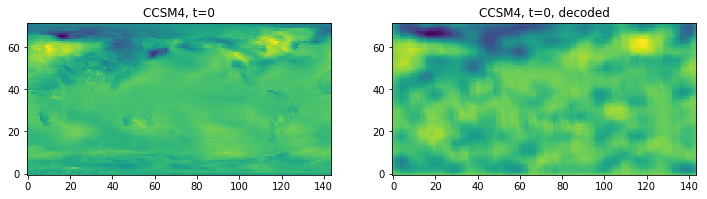

(72, 144)


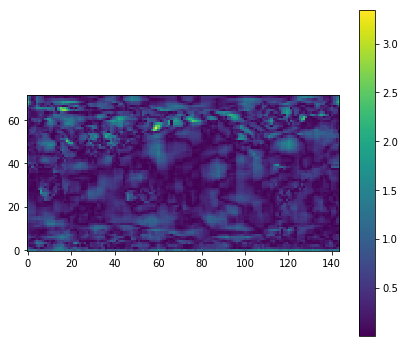

(2880, 72, 144, 1)


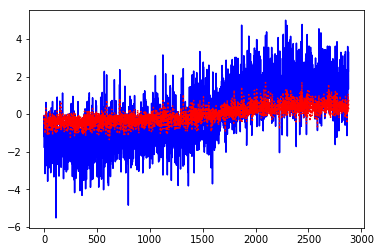

In [20]:
plot_var_spatial(X_valid, vae_model, name="tas, decoded (validation set)", c=0)
plot_var_spatial(X_valid, vae_model, name="precip, decoded (validation set)", c=1)
plot_err_spatial(X_valid, vae_model, name="tas", c=0)
plot_err_spatial(X_valid, vae_model, name="precip", c=1 )
plot_var_time(X_valid, vae_model, c=0, name='tas')
plot_var_time(X_valid, vae_model, c=1, name='precip')
#show_activations(X_valid, conv_model, conv_model.layers[2], (18,36))

# Model selection

Hyperparameter optimization for deep models

In [9]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

def load_data():
    import numpy as np
    cmip_experiment_id = 'rcp26'
    X_train = np.load('./data/X_{}_train.npy'.format(cmip_experiment_id))
    X_valid = np.load('./data/X_{}_valid.npy'.format(cmip_experiment_id))
    return X_train, X_train, X_valid, X_valid

def optimize_dense_model(X_train, y_train, X_val, y_val):
    from keras.regularizers import l2
    
    N_time, N_lat, N_lon, N_vars = X_train.shape
    def build_dense_autoencoder(latent_dims: int, regularizer=l1(1.0e-5)):
        input_0 = Input(shape=(N_lat, N_lon, N_vars))
        z = Dense(latent_dims, activation='relu', kernel_regularizer=regularizer)(Flatten()(input_0))
        def build_decoder(input_z):
            dense_out = Dense(np.product(X_train.shape[1:]), activation='linear')(input_z)
            output = Reshape(X_train.shape[1:])(dense_out)
            return output
        output_0 = build_decoder(z)
        # build standalone encoder/decoder
        encoder = Model(inputs=input_0, outputs=z)
        decoder_input = Input(shape=(latent_dims,))
        decoder_output = build_decoder(decoder_input)
        decoder = Model(inputs=decoder_input, outputs=decoder_output)
        dae = Model(inputs=input_0, outputs=output_0)
        dae.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return dae, encoder, decoder
    
    dae, dae_encoder, dae_decoder = \
        build_dense_autoencoder(latent_dims={{choice([9*18, 18*36])}}, \
                                regularizer=l2({{uniform(1.0E-5, 1.0E-2)}}))
    callbacks = [EarlyStopping(min_delta=5.0E-3, patience=3, restore_best_weights=True)]
    dae.fit(X_train, X_train, validation_data=(X_valid, X_valid), \
            batch_size=3*144, epochs=30, shuffle=True, callbacks=callbacks)
    mse, mae = dae.evaluate(X_valid, X_valid, verbose=0)
    print('Test mse/mae: {}/{}'.format(mse, mae))
    return {'loss': mse, 'status': STATUS_OK, 'model': (dae, dae_encoder, dae_decoder)}

def optimize_conv_model(X_train, y_train, X_val, y_val):
    from keras.regularizers import l2
    
    N_time, N_lat, N_lon, N_vars = X_train.shape
    def build_conv_autoencoder(n_filters: int, n_downsamples: int = 2, regularizer = l2(1.0E-5)):
        assert n_downsamples > 0
        assert n_downsamples < N_lat / 2
        relu = ReLU()
        def conv_encoder(prev_layer):
            conv_0 = Conv2D(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
            conv_1 = Conv2D(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
            conv_dn = Conv2D(n_filters, (3,3), strides=(2,2), kernel_regularizer=regularizer, padding='same')
            return relu (conv_dn (relu (conv_1 (relu (conv_0 (prev_layer))))))
        def conv_decoder(prev_layer):
            tconv_0 = Conv2DTranspose(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
            tconv_1 = Conv2DTranspose(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
            tconv_up = Conv2DTranspose(n_filters, (3,3), strides=(2,2), kernel_regularizer=regularizer, padding='same')
            return relu (tconv_up (relu (tconv_1 (relu (tconv_0 (prev_layer))))))
        def build_decoder(input_z):
            z_reshape = Reshape((latent_x,latent_y,1))
            h_decoder = z_reshape(input_z)
            for i in range(n_downsamples):
                h_decoder = conv_decoder(h_decoder)
            conv_out = Conv2D(N_vars, (3,3), padding='same')
            return conv_out(h_decoder)
    
        latent_x, latent_y = int(N_lat / 2**n_downsamples), int(N_lon / 2**n_downsamples)
        latent_dims = latent_x*latent_y
        input_0 = Input(shape=(N_lat, N_lon, N_vars))
        h_encoder = input_0
        for i in range(n_downsamples):
            h_encoder = conv_encoder(h_encoder)
        z = Dense(latent_dims, kernel_regularizer=regularizer)(Flatten()(h_encoder))
        output_0 = build_decoder(relu(z))
        # build encoder/decoder models
        encoder = Model(inputs=input_0, outputs=z)
        decoder_input = Input(shape=(latent_dims,))
        decoder_output = build_decoder(decoder_input)
        decoder = Model(inputs=decoder_input, outputs=decoder_output)
        # build end-to-end model
        cae = Model(inputs=input_0, outputs=output_0)
        cae.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return cae, encoder, decoder, latent_dims
    
    conv_model, conv_encoder, conv_decoder, _ = \
        build_conv_autoencoder(n_filters={{choice([8, 16, 32])}}, \
                               n_downsamples={{choice([1,2,3])}}, \
                               regularizer=l2({{uniform(1.0E-5, 1.0E-3)}}))
    callbacks = [EarlyStopping(min_delta=5.0E-3, patience=3)]
    conv_model.fit(X_train, X_train, batch_size=3*144, epochs=20, shuffle=True, validation_data=(X_valid, X_valid), callbacks=callbacks)
    mse, mae = conv_model.evaluate(X_valid, X_valid, verbose=0)
    print('Test mse/mae: {}/{}'.format(mse, mae))
    return {'loss': mse, 'status': STATUS_OK, 'model': (conv_model, conv_encoder, conv_decoder)}

def optimize_conv_vae_model(X_train, y_train, X_val, y_val):
    from keras.regularizers import l2
    
    def kl_loss(z_mean, z_log_sigma):
        return - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1);

    N_time, N_lat, N_lon, N_vars = X_train.shape
    def build_conv_vae(n_filters: int, n_downsamples: int = 2, beta=0.5, epsilon_std=1.0, regularizer = l2(1.0E-5)):
        """
        n_filters     : number of convolutional filters to use in encoder and decoder
        n_downsamples : number of convolutional downsampling steps to apply
        beta          : weight hyper-parameter in [0,1] for balancing between MSE and KL loss; 0.5 is equal weight
        regularizer   : Keras regularizer for convolution and dense layers
        """
        assert n_downsamples > 0
        assert n_downsamples < N_lat / 2
        latent_x, latent_y = int(N_lat / 2**n_downsamples), int(N_lon / 2**n_downsamples)
        latent_dims = latent_x*latent_y*N_vars
        print('building model with {}x{}x{} = {} latent dims'.format(latent_x, latent_y, N_vars, latent_dims))
        def conv_encoder(prev_layer):
            conv_0 = Conv2D(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
            conv_dn = Conv2D(n_filters, (3,3), strides=(2,2), kernel_regularizer=regularizer, padding='same')
            return PReLU() (conv_dn (PReLU() (conv_0 (prev_layer))))
        def conv_decoder(prev_layer):
            tconv_0 = Conv2DTranspose(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
            upsample = UpSampling2D((2,2))
            return upsample (ReLU() (tconv_0 (prev_layer)))
        def build_encoder(X_input):
            h_encoder = X_input
            for i in range(n_downsamples):
                h_encoder = conv_encoder(h_encoder)
            z_mean = Dense(latent_dims, kernel_regularizer=l2(1.0E-5))(Flatten()(h_encoder))
            z_log_sigma = Dense(latent_dims, kernel_regularizer=l2(1.0E-5))(Flatten()(h_encoder))
            return z_mean, z_log_sigma
        def build_decoder(z_mean, z_log_sigma):
            def sample_z(args):
                z_mean, z_log_sigma = args
                epsilon = K.random_normal(K.shape(z_log_sigma), mean=0.0, stddev=epsilon_std)
                return z_mean + K.exp(z_log_sigma) * epsilon
            z = Lambda(sample_z, output_shape=(latent_dims,))
            z_reshape = Reshape((latent_x,latent_y,N_vars))
            h_decoder = z_reshape (z ([z_mean, z_log_sigma]))
            for i in range(n_downsamples):
                h_decoder = conv_decoder(h_decoder)
            conv_out = Conv2D(N_vars, (3,3), padding='same')
            return conv_out(h_decoder)
    
        # encoder input
        input_0 = Input(shape=(N_lat, N_lon, N_vars), name='X')
    
        z_mean, z_log_sigma = build_encoder(input_0)
        output_0 = build_decoder(z_mean, z_log_sigma)
        # build encoder/decoder models
        encoder = Model(inputs=input_0, outputs=[z_mean, z_log_sigma])
        decoder_input_mean = Input(shape=(latent_dims,))
        decoder_input_log_sigma = Input(shape=(latent_dims,))
        decoder_output = build_decoder(decoder_input_mean, decoder_input_log_sigma)
        decoder = Model(inputs=[decoder_input_mean, decoder_input_log_sigma], outputs=decoder_output)
        # build end-to-end model
        def vae_loss(x, x_):
            mse_loss = mse(K.flatten(x), K.flatten(x_))
            return (1-beta)*mse_loss + beta*kl_loss(z_mean, z_log_sigma)
        vae = Model(inputs=input_0, outputs=output_0)
        vae.compile(optimizer='adam', loss=vae_loss, metrics=['mse', 'mae'])
        return vae, encoder, decoder, latent_dims
    
    vae_model, vae_encoder, vae_decoder, _ = \
        build_conv_vae(n_filters={{choice([4, 8, 16])}}, \
                       n_downsamples={{choice([1,2,3])}}, \
                       beta={{choice([0.5, 0.3, 0.7])}}, \
                       regularizer=l2({{uniform(1.0E-5, 1.0E-3)}}))

    callbacks = [EarlyStopping(min_delta=5.0E-3, patience=3, restore_best_weights=True)]
    vae_model.fit(X_train, X_train, batch_size=144, epochs=10, shuffle=True, \
                  validation_data=(X_valid, X_valid), callbacks=callbacks)
    vae, score_mse, score_mae = vae_model.evaluate(X_valid, X_valid, verbose=0)
    print('Test vae/mse/mae: {}/{}'.format(vae, score_mse, score_mae))
    return {'loss': score_mse, 'status': STATUS_OK, 'model': (vae_model, vae_encoder, vae_decoder)}

# run optimization for dense autoencoder
#best_run_dae, best_dae_models = optim.minimize(model=optimize_dense_model, \
#                                           data=load_data, \
#                                           algo=tpe.suggest, \
#                                           max_evals=20, \
#                                           trials=Trials(),
#                                           notebook_name='deep_embeddings')

# run optimization for conv autoencoder
#best_run_conv, best_conv_models = optim.minimize(model=optimize_conv_model, \
#                                           data=load_data, \
#                                           algo=tpe.suggest, \
#                                           max_evals=10, \
#                                           trials=Trials(),
#                                           notebook_name='deep_embeddings')

#np.save('./data/conv_best_run.npy', best_run_conv)
#conv,_,_ = best_conv_models
#conv.save_weights('./data/conv_best_run_weights.model')

# run optimization for conv-variational autoencoder
best_run_vae, best_vae_models = optim.minimize(model=optimize_conv_vae_model, \
                                           data=load_data, \
                                           algo=tpe.suggest, \
                                           max_evals=10, \
                                           trials=Trials(),
                                           notebook_name='deep_embeddings')

np.save('./data/conv_best_run.npy', best_run_vae)
vae,_,_ = best_vae_models
vae.save_weights('./data/vae_best_run_weights.model')

>>> Imports:
#coding=utf-8

try:
    import sys
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import xarray as xr
except:
    pass

try:
    import itertools as it
except:
    pass

try:
    import os.path
except:
    pass

try:
    import multiprocessing as mp
except:
    pass

try:
    import matplotlib
except:
    pass

try:
    import matplotlib.cm as cm
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import matplotlib.rcsetup as rcsetup
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    import sklearn
except:
    pass

try:
    from keras.layers import *
except:
    pass

try:
    from keras.regularizers import l1, l2
except:
    pass

try:
    from keras.models import Model
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from keras.losses import mse
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from live

KeyboardInterrupt: 

# "Optimal" model tests

In [34]:
var_i = [1]
N_vars = 1

In [35]:
dense_model_weights_filename = './data/dae_best_run_weights.model'
dense_model_params = np.load('./data/dae_best_run.npy', allow_pickle=True)
print(dense_model_params)
opt_latent_dims = 18*36
opt_l2_reg = 0.0002

{'l2': 0.0002167559913160286, 'latent_dims': 1}


In [36]:
dae, dae_encoder, dae_decoder = build_dense_autoencoder(latent_dims=opt_latent_dims, regularizer=l2(opt_l2_reg))
#dae.load_weights(dense_model_weights_filename)

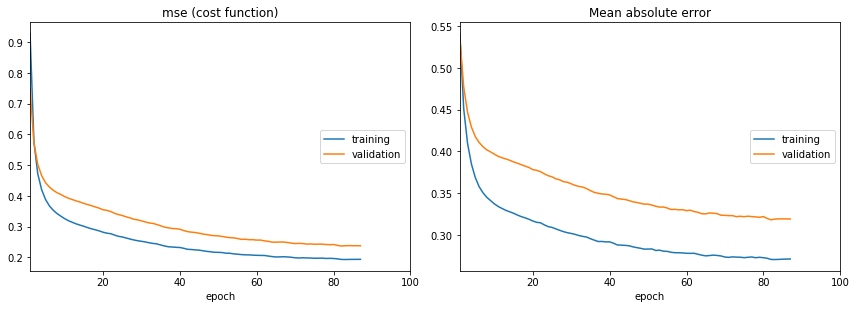

mse (cost function):
training   (min:    0.193, max:    0.928, cur:    0.193)
validation (min:    0.237, max:    0.747, cur:    0.238)

Mean absolute error:
training   (min:    0.271, max:    0.541, cur:    0.271)
validation (min:    0.318, max:    0.536, cur:    0.319)


In [37]:
callbacks = [EarlyStopping(min_delta=1.0E-3, patience=5), PlotLossesCallback()]
dae_hist = dae.fit(X_train[:,:,:,var_i], X_train[:,:,:,var_i], validation_data=(X_valid[:,:,:,var_i], X_valid[:,:,:,var_i]), \
                   batch_size=2*180, epochs=100, shuffle=True, callbacks=callbacks)

In [25]:
conv_model_weights_filename = './data/conv_best_run_weights.model'
#conv_model_params = np.load('./data/conv_best_run.npy', allow_pickle=True)
opt_n_filters = 32
opt_n_downsamples = 2
opt_l2_reg = 1.0E-4

In [42]:
conv_model, conv_encoder, conv_decoder, conv_latent_dims = \
    build_conv_autoencoder(n_filters=opt_n_filters, n_downsamples=opt_n_downsamples, regularizer=l2(opt_l2_reg))
#conv_model.load_weights(conv_model_weights_filename)

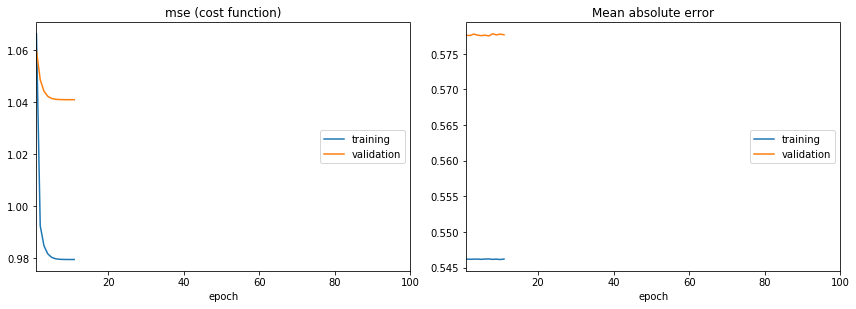

mse (cost function):
training   (min:    0.980, max:    1.066, cur:    0.980)
validation (min:    1.041, max:    1.060, cur:    1.041)

Mean absolute error:
training   (min:    0.546, max:    0.546, cur:    0.546)
validation (min:    0.578, max:    0.578, cur:    0.578)


In [43]:
callbacks = [EarlyStopping(min_delta=1.0E-3, patience=5, restore_best_weights=True), PlotLossesCallback()]
conv_hist = conv_model.fit(X_train[:,:,:,var_i], X_train[:,:,:,var_i], batch_size=2*180, epochs=100, shuffle=True, validation_data=(X_valid[:,:,:,var_i], X_valid[:,:,:,var_i]), callbacks=callbacks)

In [29]:
vae_model_weights_filename = './data/vae_best_run_weights.model'
vae_model_params = np.load('./data/conv_best_run.npy', allow_pickle=True)
print(vae_model_params)
opt_n_filters = 16
opt_n_downsamples = 2
opt_beta = 0.3
opt_l2_reg = 2.0E-4

{'l2': 0.00021732817223200993, 'n_downsamples': 0, 'n_filters': 1, 'beta': 1}


In [30]:
vae_model, vae_encoder, vae_decoder, vae_latent_dims = \
    build_conv_vae(n_filters=opt_n_filters, beta=opt_beta, regularizer=l2(opt_l2_reg))
vae_model.summary()

building model with 18x36x1 = 648 latent dims
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 72, 144, 1)   0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 72, 144, 16)  160         X[0][0]                          
__________________________________________________________________________________________________
p_re_lu_2 (PReLU)               (None, 72, 144, 16)  165888      conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 36, 72, 16)   2320        p_re_lu_2[0][0]                  
_______________________________________________________________

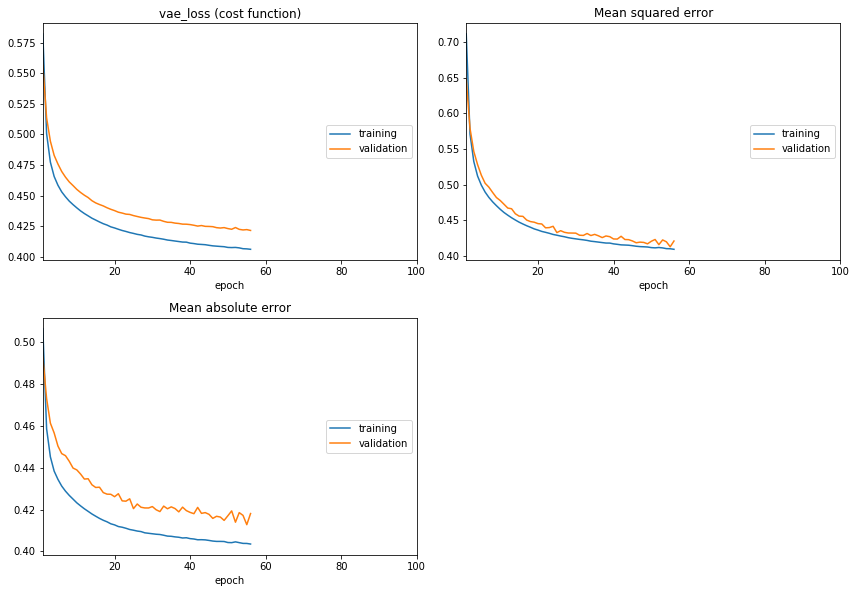

vae_loss (cost function):
training   (min:    0.406, max:    0.582, cur:    0.406)
validation (min:    0.421, max:    0.557, cur:    0.421)

Mean squared error:
training   (min:    0.409, max:    0.711, cur:    0.409)
validation (min:    0.413, max:    0.648, cur:    0.421)

Mean absolute error:
training   (min:    0.404, max:    0.506, cur:    0.404)
validation (min:    0.413, max:    0.493, cur:    0.418)


In [40]:
callbacks = [EarlyStopping(min_delta=1.0E-3, patience=5, restore_best_weights=True), PlotLossesCallback()]
vae_model.fit(X_train[:,:,:,var_i], X_train[:,:,:,var_i], batch_size=2*180, epochs=100, shuffle=True, \
              validation_data=(X_valid[:,:,:,var_i], X_valid[:,:,:,var_i]), callbacks=callbacks)

In [41]:
plot_var_spatial(X_valid, vae_model, name="tas, decoded (validation set)", c=0, t=300)
plot_var_spatial(X_valid, vae_model, name="precip, decoded (validation set)", c=1, t=300)
plot_err_spatial(X_valid, vae_model, name="tas", c=0, t=300)
plot_err_spatial(X_valid, vae_model, name="precip", c=1, t=300)
plot_var_time(X_valid, vae_model, c=0, name='tas')
plot_var_time(X_valid, vae_model, c=1, name='precip')
#show_activations(X_valid, conv_model, conv_model.layers[2], (18,36))

ValueError: Error when checking input: expected X to have shape (72, 144, 1) but got array with shape (72, 144, 2)

In [62]:
z_means, z_sigmas = vae_encoder.predict(X_valid)

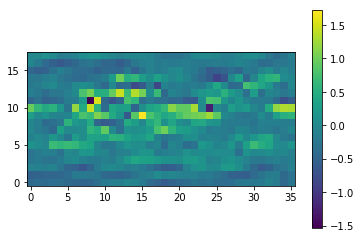

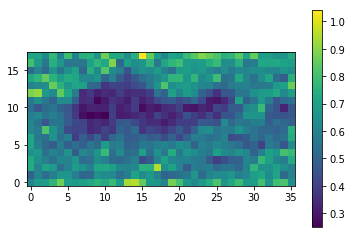

In [70]:
z_mean_t = z_means[300].reshape((18, 36, 2))
z_sigma_t = z_sigmas[300].reshape((18,36,2))
plt.imshow(z_mean_t[:,:,0], origin='lower')
plt.colorbar()
plt.show()
plt.imshow(np.exp(z_sigma_t[:,:,0]), origin='lower')
plt.colorbar()
plt.show()

In [33]:
dae.save_weights('./data/dae_opt_weights_tas.model')
conv_model.save_weights('./data/conv_opt_weights_tas.model')
vae_model.save_weights('./data/vae_opt_weights_tas.model')

## VAE time period training

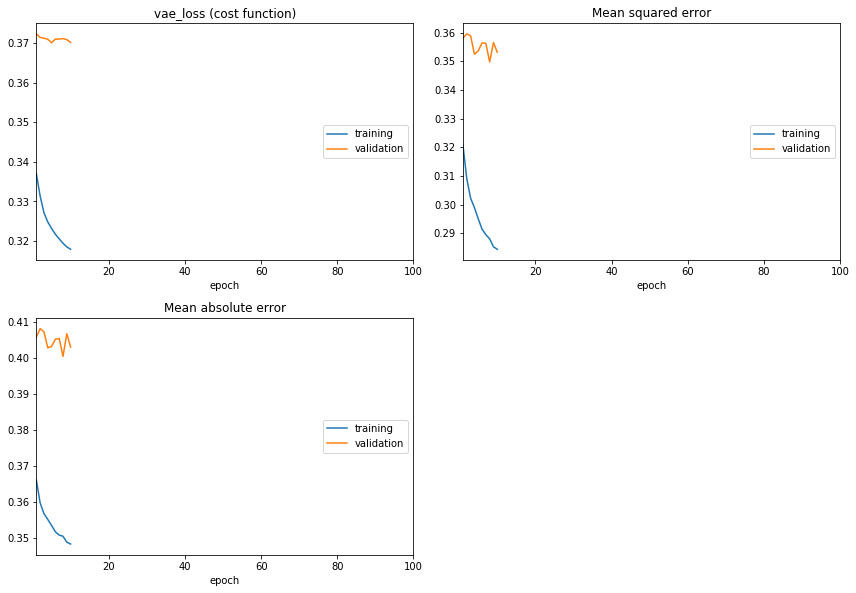

vae_loss (cost function):
training   (min:    0.318, max:    0.337, cur:    0.318)
validation (min:    0.370, max:    0.372, cur:    0.370)

Mean squared error:
training   (min:    0.284, max:    0.321, cur:    0.284)
validation (min:    0.350, max:    0.360, cur:    0.353)

Mean absolute error:
training   (min:    0.348, max:    0.366, cur:    0.348)
validation (min:    0.401, max:    0.408, cur:    0.403)
VAE loss/mse/mae at t=240 years: 0.42800689223739835/0.4516516178846359/0.48092675805091856


In [81]:
vae_model_incr, vae_encoder_incr, vae_decoder_incr, vae_latent_dims = \
    build_conv_vae(n_filters=opt_n_filters, beta=opt_beta, regularizer=l2(opt_l2_reg))
vae_model_incr.summary()

# 30 year time increments
t_30_yr = 360
timesteps = np.arange(start=t_30_yr, stop=N_time+1, step=t_30_yr)
max_epochs_per_iter = 100
for i, t in enumerate(timesteps):
    X_train_t = X_train[N_models_train*i*t_30_yr:N_models_train*t]
    X_valid_t = X_valid[N_models_valid*i*t_30_yr:N_models_valid*t]
    callbacks = [EarlyStopping(min_delta=1.0E-5, patience=5, restore_best_weights=True), PlotLossesCallback()]
    vae_model_incr.fit(X_train_t, X_train_t, batch_size=2*180, epochs=max_epochs_per_iter, shuffle=True, \
                  validation_data=(X_valid_t, X_valid_t), callbacks=callbacks)
    vae_model_incr.save_weights('./data/vae_model_weights_t{}.model'.format(i))
    vae_loss, mse, mae = vae_model_incr.evaluate(X_valid, X_valid, verbose=0)
    print('VAE loss/mse/mae at t={} years: {}/{}/{}'.format((i+1)*30, vae_loss, mse, mae))